In [1]:
import pandas as pd
from os import path, listdir, mkdir
import numpy as np
from scipy import stats
import statsmodels.sandbox.stats.multicomp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import mannwhitneyu

In [2]:
# sample_groups = [['3821B', '3821K'], #glioblastoma 2017
#                  ['4114B', '4114K'],
#                  ['4466B', '4466K'],
#                  ['5222B', '5222K'],
#                  ['5522B', '5522K'],
#                  ['6067B', '6067K'],
#                  ['6138B', '6138K'],
#                  ['5410B', '5410K']]
sample_groups_glioblastoma_2019 = [['3821a', '3821K'],
                                   ['4114a', '4114K'],
                                   ['5522a', '5522K'],
                                   ['6067a', '6067K'],
                                   ['ANa', 'ANK']]
sample_groups_time_infa = [['4_A', '4_K'],
                          ['24_A', '24_K'],
                          ['48_A', '48_K']] 

sample_groups_time_infg = [['4_G', '4_K'],
                          ['24_G', '24_K'],
                          ['48_G', '48_K']]

# sample_groups = [['5522a', '5522K']]
# sample_groups = [['3821K', '4114K'], #glioblastoma batch server
#                  ['5522K', '4114K'],
#                  ['6067K', '4114K'],
#                  ['ANK', '4114K']]
sample_groups_glioblastoma_2017_infa = [['i_A', 'i_K'], 
                                        ['b_A', 'b_K']]
sample_groups_glioblastoma_2017_infb = [['i_B', 'i_K'], 
                                        ['b_B', 'b_K']]

sample_groups_yeast_EtOH = [['Normal_WT', 'EtOH_WT'],
                            ['Normal_YPL', 'EtOH_YPL'],
                            ['Normal_RPN4', 'EtOH_RPN4']]

sample_groups_yeast_4NQO = [['Normal_WT', '4NQO_WT'], 
                            ['Normal_YPL', '4NQO_YPL'],
                            ['Normal_RPN4', '4NQO_RPN4']]

sample_groups_a172_dbtrg = [['DBTRG_I', 'DBTRG_K'], 
                            ['A172_I', 'A172_K']]
sample_groups_yeast_lipids_normal = [['Normal_WT', 'Normal_RPN4'],
                                    ['Normal_WT', 'Normal_YPL'],
                                    ['Normal_RPN4', 'Normal_YPL']]
sample_groups_yeast_lipids_p3_EtOH = [['EtOH_WT', 'EtOH_RPN4'],
                                      ['EtOH_WT', 'EtOH_YPL'],
                                      ['EtOH_RPN4', 'EtOH_YPL']]
sample_groups_yeast_lipids_p3_4NQO = [['4NQO_WT', '4NQO_RPN4'],
                                      ['4NQO_WT', '4NQO_YPL'],
                                      ['4NQO_RPN4', '4NQO_YPL']]

# sample_groups = [['ME_T', 'ME_K'], #melanoma + T
#                  ['P_T', 'P_K'],
#                  ['G_T', 'G_K'],
#                  ['335_T', '335_K'],
#                  ['KOR_T', 'KOR_K'],
#                  ['IL_T', 'IL_K'],
#                  ['SI_T', 'SI_K'],
#                  ['82_T', '82_K'],
#                  ['KIS_T', 'KIS_K']]

sample_groups_melanoma = [['T', 'K']] 

sample_groups_melanoma_inf = [['wild', 'vel'],
                              ['wild', 'inf'],
                              ['wild', 'vel-inf']]

sample_groups_dict = {'a172_dbtrg' : sample_groups_a172_dbtrg,
                      'glioblastoma_2017_infa' : sample_groups_glioblastoma_2017_infa,
                      'glioblastoma_2017_infb' : sample_groups_glioblastoma_2017_infb,
                      'glioblastoma_2019' : sample_groups_glioblastoma_2019,
                      'melanoma' : sample_groups_melanoma,
                      'melanoma_inf' : sample_groups_melanoma_inf,
                      'yeast_4NQO' : sample_groups_yeast_4NQO,
                      'yeast_EtOH' : sample_groups_yeast_EtOH,
                      'yeast_lipids_normal' : sample_groups_yeast_lipids_normal,
                      'yeast_lipids_p3_EtOH' : sample_groups_yeast_lipids_p3_EtOH,
                      'yeast_lipids_p3_4NQO' : sample_groups_yeast_lipids_p3_4NQO,
                      'time_infa' : sample_groups_time_infa,
                      'time_infg' : sample_groups_time_infg
                     }

control_group_dict = {'a172_dbtrg' : '_K',
                      'glioblastoma_2017_infa' : '_K',
                      'glioblastoma_2017_infb' : '_K',
                      'glioblastoma_2019' : 'K',
                      'melanoma' : 'K',
                      'melanoma_inf' : 'wild',
                      'yeast_4NQO' : 'Normal_',
                      'yeast_EtOH' : 'Normal_',
                      'yeast_lipids_normal' : 'Normal_WT',
                      'yeast_lipids_p3_EtOH' : 'EtOH_WT',
                      'yeast_lipids_p3_4NQO' : '4NQO_WT',
                      'time_infa' : '_K',
                      'time_infg' : '_K'
                      }

In [3]:
def stat_test(input_dir, output_dir, nsaf_data_name, sample_file, 
              alpha = 0.05, stattest = 'ttest_ind'):
    
    tmp_dict = {}
    sns.set(style = 'whitegrid') 
    sample_groups = sample_groups_dict[nsaf_data_name]
    s_file = pd.read_csv(sample_file, index_col = 'File Name', header = 0)
    
    for sample_type in sample_groups:
        df = pd.DataFrame()
        s1 = pd.DataFrame()
        s2 = pd.DataFrame()
        MV_df = pd.DataFrame()
        
        control_group = control_group_dict[nsaf_data_name]
        
        if ('EtOH' in sample_type[0]) | ('4NQO' in sample_type[0]) | ('Normal' in sample_type[0]):
            sample_name = sample_type[1] + '_to_' + sample_type[0] #!!!!!!!
            control_group = sample_type[0]
        else:
            sample_name = sample_type[1].split(control_group)[0]
            
        output = path.join(output_dir, 'MinDet' ,nsaf_data_name)
        
        if path.exists(path.join(output_dir, 'MinDet')) == False:
            mkdir(path.join(output_dir, 'MinDet'))
        if path.exists(output) == False:
            mkdir(output)
        
        for filename in listdir(input_dir):
            bool_id = False
            
            file_id = filename.split('_identipy')[0].split('_protein_groups.tsv')[0]
            bool_id = '_protein_groups.tsv' in filename
                
            if (bool_id) and (file_id in s_file.index):
                s_type = s_file.loc[file_id, 'SampleID']
                if s_type in sample_type:
                    d = pd.read_csv(path.join(input_dir, filename), delimiter = '\t')
                    d['Protein'] = d['dbname'] + ' ' + d['description']

                    data_name = file_id + '/' + s_type 
                    d.set_index(d['Protein'], inplace = True)
                    d.rename(columns = {'NSAF': data_name}, inplace = True)

                    df = pd.concat([df, d[data_name]], axis = 1)
                    
        for col in df.columns:
            if control_group in col.split('/')[1]:
                s1[col] = df[col].copy(deep = True)
            else:
                s2[col] = df[col].copy(deep = True)      
        print(s1.columns, '\n', s2.columns)
    
        df['% NaNs'] = df.isna().sum(axis = 1)/len(df.columns)
        MV = np.mean(df['% NaNs'].values)
        
#         g = sns.histplot(data = df, x = '% NaNs', kde = True, bins = len(s1.columns) + len(s2.columns))
#         g.set_title('% NaNs {}'.format(sample_name))
#         g.set_xticks(np.arange(0, 1, 0.1))
#         plt.show()
#         g.get_figure().savefig(path.join(output, '{} % NaN distribution.png'.format(sample_name)), dpi = 300)
#         plt.close()
        
        s1_dict = {}
        for col in s1.columns:
            s1[col] = s1[col].apply(lambda x: np.log2(x))
            median = s1[col].median(axis = 0, skipna  = True)
            std = s1[col].std(axis = 0, skipna = True)
            s1[col] = s1[col].apply(lambda x: (x - median)/std)
            s1_dict[col] = s1[col].count()
        
        s1['% NaN'] = s1.isna().sum(axis = 1)/len(s1.columns)
        g = sns.histplot(data = s1, x = '% NaN', kde = True, bins = len(s1.columns))
        g.set_title('% NaN control group {} {}'.format(nsaf_data_name, sample_name))
        g.set_xticks(np.arange(0, 1, 0.1))
        plt.show()
        g.get_figure().savefig(path.join(output, '{} {} % NaN distribution control.png'.format(nsaf_data_name, sample_name)), 
                               dpi = 300, format = 'svg')
        plt.close() 
        drop_list_proteins_s1 = s1[s1['% NaN'] >= 0.5].index
        
        s2_dict = {}
        for col in s2.columns:
            s2[col] = s2[col].apply(lambda x: np.log2(x))
            median = s2[col].median(axis = 0, skipna = True)
            std = s2[col].std(axis = 0, skipna = True)
            s2[col] = s2[col].apply(lambda x: (x - median)/std)
            s2_dict[col] = s2[col].count()
            
        s2['% NaN'] = s2.isna().sum(axis = 1)/len(s2.columns) 
        g = sns.histplot(data = s2, x = '% NaN', kde = True, bins = len(s2.columns))
        g.set_title('% NaN stress group {} {}'.format(nsaf_data_name, sample_name))
        g.set_xticks(np.arange(0, 1, 0.1))
        plt.show()
        g.get_figure().savefig(path.join(output, '{} {} % NaN distribution stress'.format(nsaf_data_name, sample_name)), 
                               dpi = 300)
        plt.close() 
        drop_list_proteins_s2 = s2[s2['% NaN'] >= 0.5].index
        
        drop_list_proteins = drop_list_proteins_s1.intersection(drop_list_proteins_s2)
        print('{} proteins are dropped'.format(len(drop_list_proteins)))
       
        s1.drop(labels = drop_list_proteins, axis = 0, inplace = True)
        s1[s1['% NaN'] == 1].to_csv(path.join(output, 'absent_prots_control_{}_{}.tsv'.format(nsaf_data_name, sample_name)), 
                                    sep = '\t')
        s1.drop(labels = ['% NaN'], axis = 1, inplace = True)
        
        s2.drop(labels = drop_list_proteins, axis = 0, inplace = True)
        s2[s2['% NaN'] == 1].to_csv(path.join(output, 'absent_prots_stress_{}_{}.tsv'.format(nsaf_data_name, sample_name)), 
                                                                                         sep = '\t')
        s2.drop(labels = ['% NaN'], axis = 1, inplace = True)
        
        for col in s1.columns:
            MV_df.loc[col, 'percent'] = s1[col].isna().sum(axis = 0)/len(s1[col])
        control_mv_mean = MV_df[~MV_df.isin(s1)].dropna().mean(axis = 0)
        
        for col in s2.columns:
            MV_df.loc[col, 'percent'] = s2[col].isna().sum(axis = 0)/len(s2[col])
        stress_mv_mean = MV_df[~MV_df.isin(s2)].dropna().mean(axis = 0)
      
        s1.fillna(s1.min(axis = 0), axis = 0, inplace = True)    
        s2.fillna(s2.min(axis = 0), axis = 0, inplace = True)
        
        s1['SW_pval'] = s1.apply(lambda x: stats.shapiro(x).pvalue, axis = 1)
        s1_SW_pval = s1['SW_pval'].copy(deep =  True)
        sw_proteins_list_s1 = s1[s1['SW_pval'] < 0.05].index.copy(deep = True)
        Ns1 = s1[s1['SW_pval'] < 0.05].shape[0]/s1.shape[0]
        
        g = sns.histplot(data = s1, x = 'SW_pval', kde = True, stat = 'percent')
        g.set_title('Shapiro-Wilk p-value control group {} {}'.format(nsaf_data_name, sample_name))
        g.set_xticks(np.arange(0, 1, 0.1))
        plt.text(s = '{} % hypotheses rejected'.format(round(100*Ns1)), y = 10, x = 0.5)
        plt.show()
        g.get_figure().savefig(path.join(output, '{} {} SW pval control'.format(nsaf_data_name, sample_name)), 
                               dpi = 300)
        plt.close() 
        s1.drop(labels = ['SW_pval'], axis = 1, inplace = True)
        
        s2['SW_pval'] = s2.apply(lambda x: stats.shapiro(x).pvalue, axis = 1)
        s2_SW_pval = s2['SW_pval'].copy(deep = True)
        sw_proteins_list_s2 = s2[s2['SW_pval'] < 0.05].index.copy(deep = True)
        Ns2 = s2[s2['SW_pval'] < 0.05].shape[0]/s2.shape[0]
        
        g = sns.histplot(data = s2, x = 'SW_pval', kde = True, stat = 'percent')
        g.set_title('Shapiro-Wilk p-value stress group {} {}'.format(nsaf_data_name, sample_name))
        g.set_xticks(np.arange(0, 1, 0.1))
        plt.text(s =  '{} % hypotheses rejected'.format(round(100*Ns2)), y = 10, x = 0.5)
        plt.show()
        g.get_figure().savefig(path.join(output, '{} {} SW pval stress'.format(nsaf_data_name, sample_name)), 
                               dpi = 300)
        plt.close() 
        s2.drop(labels = ['SW_pval'], axis = 1, inplace = True)
        
        sw_proteins_list = list(set([*sw_proteins_list_s1, *sw_proteins_list_s2]))
        
        s1 = s1.sort_index()
        s2 = s2.sort_index()
        
        tmp_s1 = s1.loc[sw_proteins_list].values.tolist()
        tmp_s2 = s2.loc[sw_proteins_list].values.tolist()
        
        MW_pval = pd.Series(data = [mannwhitneyu(row1, row2)[1] for row1, row2 in zip(tmp_s1, tmp_s2)], 
                            index = sw_proteins_list)
        
        tmp = s1.index
        s1 = s1[s1.index.isin(s2.index)]
        s2 = s2[s2.index.isin(tmp)]
     
        rows = len(s1.columns) // 3 + 1*(len(s1.columns) % 3 != 0)
        fig, axs = plt.subplots(rows, 3, figsize = (15, rows*2.7), squeeze = False)
        fig.suptitle('%s %s control %d %% mv' % (nsaf_data_name, sample_name, round(100*control_mv_mean)))
        fig.subplots_adjust(hspace = .5, wspace = .5, top = 0.95) 
        axs = axs.ravel() 
        
        i = 0
        for col in s1.columns:
            tmp = sns.histplot(data = s1, ax = axs[i], x = col, kde = True)
            tmp.set_xlabel(col, fontsize = 12)
            axs[i].text(0.1, 0.78, '{} % mv \n{} identifications'.format(round(100*MV_df.loc[col, 'percent']), s1_dict[col]), 
                        transform = axs[i].transAxes, fontsize = 11)
            i+=1
        for j in range(i, rows*3):
            fig.delaxes(axs.flatten()[j])
            
        fig.savefig(path.join(output, '{}_{}_hists_control.png'.format(nsaf_data_name, sample_name)), dpi = 300)
        
        plt.close()
        
        rows = len(s2.columns) // 3 + 1*(len(s2.columns) % 3 != 0)
        fig, axs = plt.subplots(rows, 3, figsize = (15, rows*2.7), squeeze = False)
        fig.suptitle('%s %s stress %d %% mv' % (nsaf_data_name, sample_name, round(100*stress_mv_mean)))
        fig.subplots_adjust(hspace = .5, wspace = .5, top = 0.95) 
        axs = axs.ravel() 
        
        i = 0
        for col in s2.columns:
            tmp = sns.histplot(data = s2, ax = axs[i], x = col, kde = True)
            tmp.set_xlabel(col, fontsize = 12)
            axs[i].text(0.1, 0.78, '{} % mv \n{} identifications'.format(round(100*MV_df.loc[col, 'percent']), s2_dict[col]), 
                        transform = axs[i].transAxes, fontsize = 11)
            i+=1
        for j in range(i, rows*3):
            fig.delaxes(axs.flatten()[j])
            
        fig.savefig(path.join(output, '{}_{}_hists_stress.png'.format(nsaf_data_name, sample_name)), dpi = 300)
        
        plt.close()
        
        s1_stat = s1.values.tolist()
        s2_stat = s2.values.tolist()
        print(len(s1_stat), len(s2_stat))

        if stattest == 'ttest_ind':
            pval = pd.Series(data = [stats.ttest_ind(row1, row2)[1] for row1, row2 in zip(s1_stat, s2_stat)], index = s1.index)
        if stattest == 'ttest_rel':
            pval = pd.Series(data = [stats.ttest_rel(row1, row2)[1] for row1, row2 in zip(s1_stat, s2_stat)], index = s1.index)

        new_df = pd.merge(s1, s2, left_index=True, right_index=True)
        new_df['pval'] = pval
        new_df = new_df.dropna(axis = 0, subset = ['pval'])

        new_df['fdr_BH'] = statsmodels.sandbox.stats.multicomp.multipletests(new_df['pval'], 
                                                                         method = 'fdr_bh', alpha = alpha)[1]
        new_df['Protein'] = new_df.index
        new_df['ProteinID'] = new_df.Protein.apply(lambda x: x.split('|')[1])
        new_df['Gene'] = new_df.Protein.astype(str).apply(lambda x: x.split('GN=')[1].split(' ')[0] 
                                                              if 'GN=' in x else x.split(' ')[0])
        new_df.drop(labels = ['Protein'], axis = 1, inplace = True)
        new_df['-log10(fdr_BH)'] = new_df['fdr_BH'].apply(lambda x: -np.log10(x))
        new_df['log2(fold_change)'] = s2.mean(axis = 1) - s1.mean(axis = 1)
        
        control_col_name = sample_type[0] + '_SW_pval'
        stress_col_name = sample_type[1] + '_SW_pval'
        
        new_df[control_col_name] = s1_SW_pval
        new_df[stress_col_name] = s2_SW_pval
        
        new_df['MW_pval'] = MW_pval
        
        fdr_MW_df = new_df[new_df['MW_pval'].notna() == True].MW_pval
        fdr_MW = statsmodels.sandbox.stats.multicomp.multipletests(fdr_MW_df, 
                                                                         method = 'fdr_bh', alpha = alpha)[1]
        new_df['fdr_BH_MW'] = pd.Series(data = fdr_MW, index = fdr_MW_df.index)
        
        print(round(100*new_df[new_df['MW_pval'] > 0.05].shape[0]/new_df['MW_pval'].count()))
        
        new_df.to_csv(path.join(output, 'NSAF_t-test_{}_{}.tsv'.format(nsaf_data_name, sample_name)), 
                                                                                         sep = '\t')
        
        tmp_dict['{}_{}'.format(nsaf_data_name, sample_name)] = [MV, Ns1, Ns2]
        MV_df.to_csv(path.join(output, 'MV_stat_{}_{}.csv'.format(nsaf_data_name, sample_name)), sep = '\t')
        
    return tmp_dict

Index(['OEI13665/4_K', 'OEI13635/4_K', 'OEI13603/4_K', 'OEI13601/4_K',
       'OEI13655/4_K', 'OEI13641/4_K', 'OEI13597/4_K', 'OEI13639/4_K'],
      dtype='object') 
 Index(['OEI13515/4_A', 'OEI13645/4_A', 'OEI13566/4_A', 'OEI13536/4_A',
       'OEI13647/4_A', 'OEI13552/4_A', 'OEI13627/4_A', 'OEI13605/4_A'],
      dtype='object')


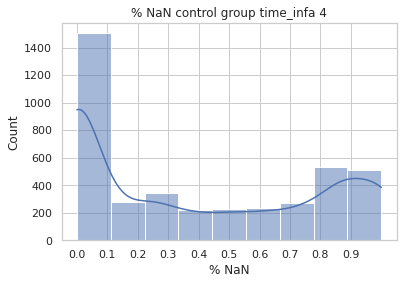

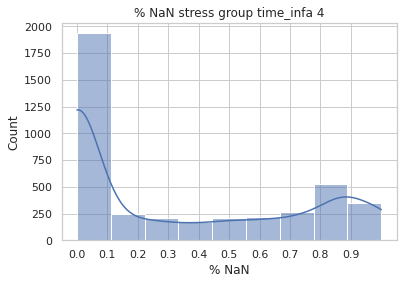

1417 proteins are dropped


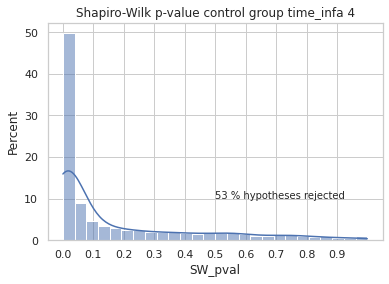

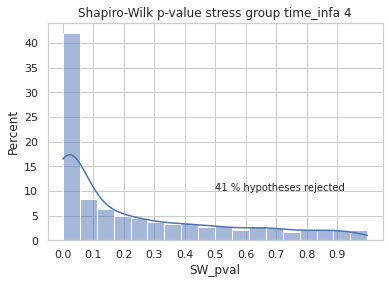

2709 2709
76
Index(['OEI13629/24_K', 'OEI13619/24_K', 'OEI13617/24_K', 'OEI13544/24_K',
       'OEI13513/24_K', 'OEI13520/24_K', 'OEI13572/24_K', 'OEI13522/24_K'],
      dtype='object') 
 Index(['OEI13528/24_A', 'OEI13667/24_A', 'OEI13546/24_A', 'OEI13591/24_A',
       'OEI13631/24_A', 'OEI13507/24_A', 'OEI13582/24_A', 'OEI13540/24_A'],
      dtype='object')


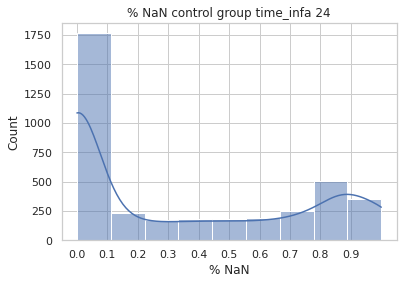

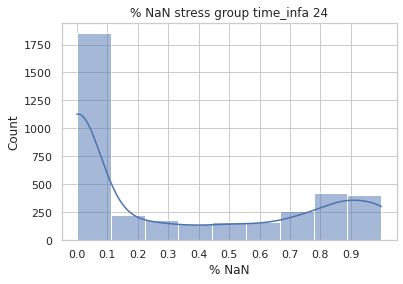

1252 proteins are dropped


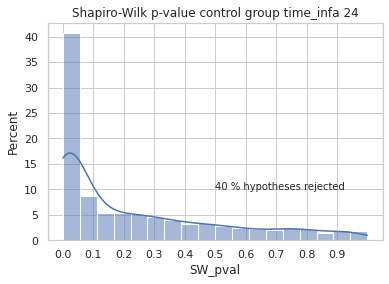

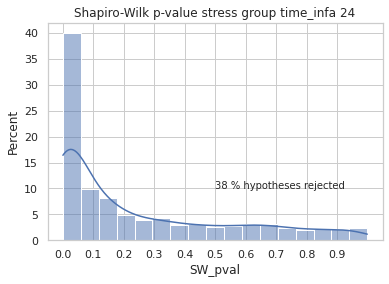

2577 2577
78
Index(['OEI13564/48_K', 'OEI13534/48_K', 'OEI13526/48_K', 'OEI13671/48_K',
       'OEI13607/48_K', 'OEI13562/48_K', 'OEI13625/48_K', 'OEI13651/48_K'],
      dtype='object') 
 Index(['OEI13548/48_A', 'OEI13558/48_A', 'OEI13574/48_A', 'OEI13609/48_A',
       'OEI13511/48_A', 'OEI13509/48_A', 'OEI13517/48_A', 'OEI13599/48_A'],
      dtype='object')


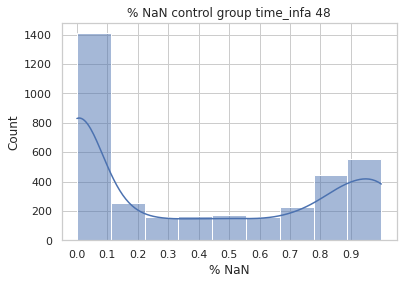

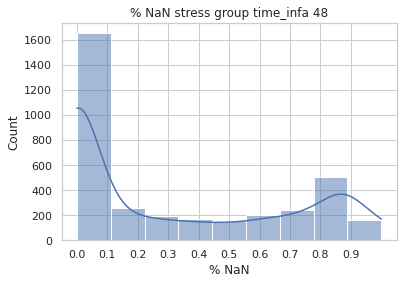

1202 proteins are dropped


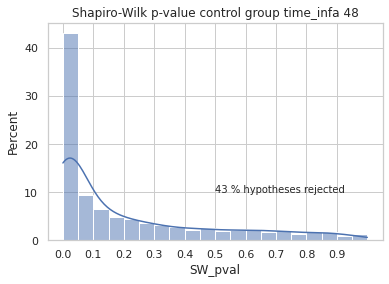

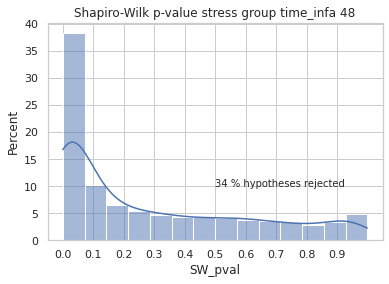

2337 2337
82
Index(['OEI13665/4_K', 'OEI13635/4_K', 'OEI13603/4_K', 'OEI13601/4_K',
       'OEI13655/4_K', 'OEI13641/4_K', 'OEI13597/4_K', 'OEI13639/4_K'],
      dtype='object') 
 Index(['OEI13661/4_G', 'OEI13611/4_G', 'OEI13657/4_G', 'OEI13570/4_G',
       'OEI13538/4_G', 'OEI13613/4_G'],
      dtype='object')


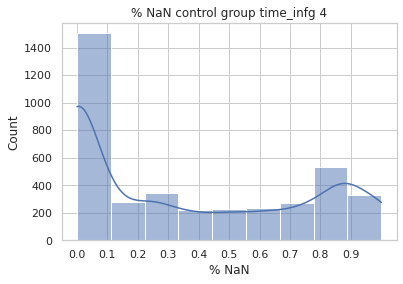

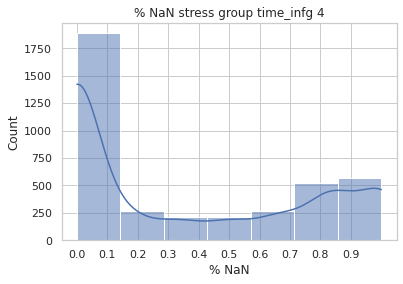

1320 proteins are dropped


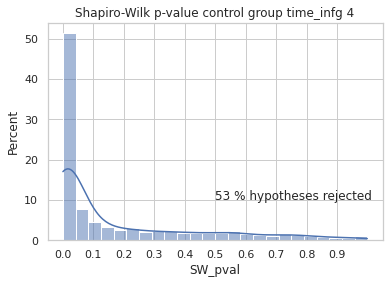

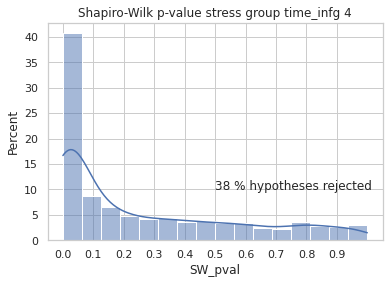

2623 2623
73
Index(['OEI13629/24_K', 'OEI13619/24_K', 'OEI13617/24_K', 'OEI13544/24_K',
       'OEI13513/24_K', 'OEI13520/24_K', 'OEI13572/24_K', 'OEI13522/24_K'],
      dtype='object') 
 Index(['OEI13580/24_G', 'OEI13637/24_G', 'OEI13663/24_G', 'OEI13593/24_G',
       'OEI13568/24_G', 'OEI13556/24_G', 'OEI13621/24_G'],
      dtype='object')


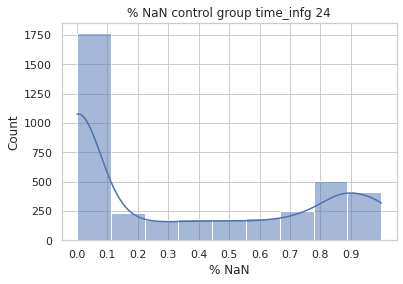

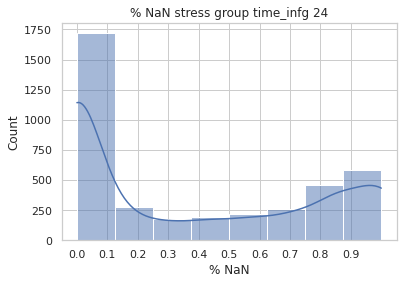

1185 proteins are dropped


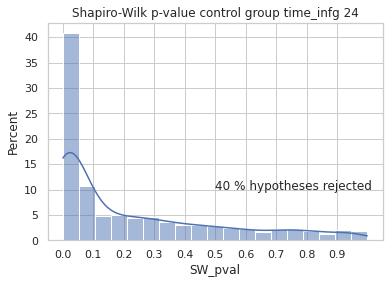

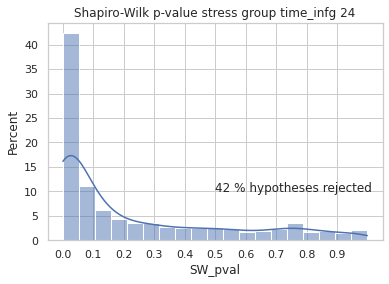

2705 2705
55
Index(['OEI13564/48_K', 'OEI13534/48_K', 'OEI13526/48_K', 'OEI13671/48_K',
       'OEI13607/48_K', 'OEI13562/48_K', 'OEI13625/48_K', 'OEI13651/48_K'],
      dtype='object') 
 Index(['OEI13554/48_G', 'OEI13530/48_G', 'OEI13653/48_G', 'OEI13576/48_G',
       'OEI13578/48_G', 'OEI13595/48_G', 'OEI13623/48_G', 'OEI13649/48_G'],
      dtype='object')


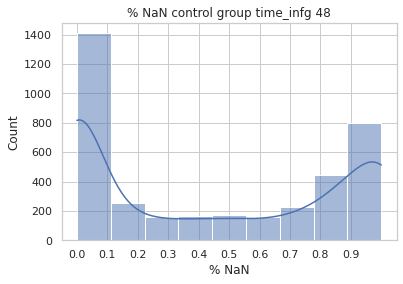

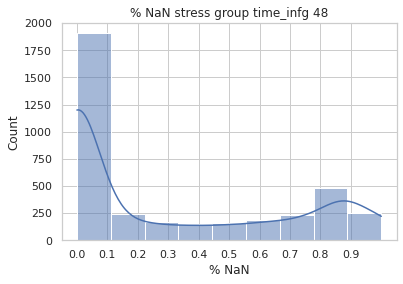

1201 proteins are dropped


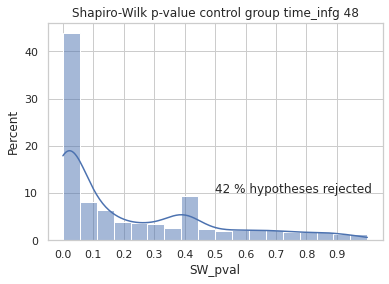

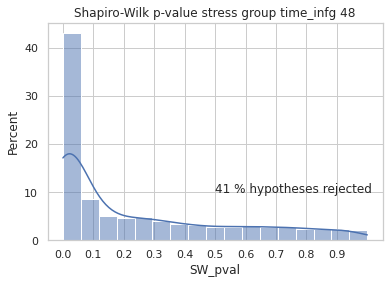

2580 2580
56


In [5]:
mv_dict ={}
mv_dict.update(stat_test(input_dir = '/home/kae-13-1/Metrics/time_inf_raw/frager_scavager', 
          output_dir = '/home/kae-13-1/Metrics/time_inf_raw/frager_scavager', nsaf_data_name = 'time_infa', 
          sample_file = '/home/kae-13-1/Metrics/other/time_inf_samplefile.csv', stattest = 'ttest_ind'))
mv_dict.update(stat_test(input_dir = '/home/kae-13-1/Metrics/time_inf_raw/frager_scavager', 
          output_dir = '/home/kae-13-1/Metrics/time_inf_raw/frager_scavager', nsaf_data_name = 'time_infg', 
          sample_file = '/home/kae-13-1/Metrics/other/time_inf_samplefile.csv', stattest = 'ttest_ind'))

['4NQO_WT', '4NQO_RPN4'] 4NQO_WT
['4NQO_WT', '4NQO_RPN4'] 4NQO_WT
['4NQO_WT', '4NQO_RPN4'] Normal_YPL
['4NQO_WT', '4NQO_RPN4'] Normal_RPN4
['4NQO_WT', '4NQO_RPN4'] 4NQO_YPL
['4NQO_WT', '4NQO_RPN4'] Normal_WT
['4NQO_WT', '4NQO_RPN4'] 4NQO_RPN4
['4NQO_WT', '4NQO_RPN4'] Normal_WT
['4NQO_WT', '4NQO_RPN4'] Normal_YPL
['4NQO_WT', '4NQO_RPN4'] Normal_RPN4
['4NQO_WT', '4NQO_RPN4'] Normal_RPN4
['4NQO_WT', '4NQO_RPN4'] 4NQO_YPL
['4NQO_WT', '4NQO_RPN4'] 4NQO_WT
['4NQO_WT', '4NQO_RPN4'] 4NQO_WT
['4NQO_WT', '4NQO_RPN4'] 4NQO_RPN4
['4NQO_WT', '4NQO_RPN4'] 4NQO_YPL
['4NQO_WT', '4NQO_RPN4'] 4NQO_YPL
['4NQO_WT', '4NQO_RPN4'] 4NQO_RPN4
['4NQO_WT', '4NQO_RPN4'] Normal_YPL
['4NQO_WT', '4NQO_RPN4'] Normal_WT
['4NQO_WT', '4NQO_RPN4'] 4NQO_RPN4
['4NQO_WT', '4NQO_RPN4'] Normal_RPN4
['4NQO_WT', '4NQO_RPN4'] Normal_WT
['4NQO_WT', '4NQO_RPN4'] 4NQO_YPL
['4NQO_WT', '4NQO_RPN4'] 4NQO_YPL
['4NQO_WT', '4NQO_RPN4'] Normal_RPN4
['4NQO_WT', '4NQO_RPN4'] 4NQO_WT
['4NQO_WT', '4NQO_RPN4'] Normal_WT
['4NQO_WT', '4NQO_RPN4'

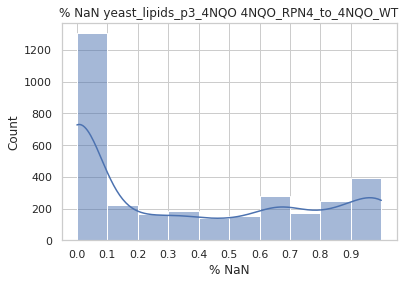

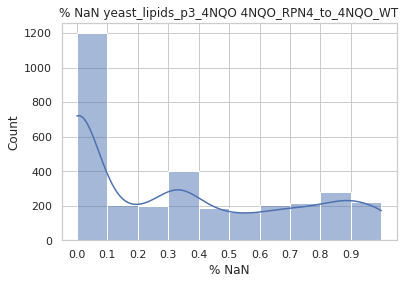

3270 3270
['4NQO_WT', '4NQO_YPL'] 4NQO_WT
['4NQO_WT', '4NQO_YPL'] 4NQO_WT
['4NQO_WT', '4NQO_YPL'] Normal_YPL
['4NQO_WT', '4NQO_YPL'] Normal_RPN4
['4NQO_WT', '4NQO_YPL'] 4NQO_YPL
['4NQO_WT', '4NQO_YPL'] Normal_WT
['4NQO_WT', '4NQO_YPL'] 4NQO_RPN4
['4NQO_WT', '4NQO_YPL'] Normal_WT
['4NQO_WT', '4NQO_YPL'] Normal_YPL
['4NQO_WT', '4NQO_YPL'] Normal_RPN4
['4NQO_WT', '4NQO_YPL'] Normal_RPN4
['4NQO_WT', '4NQO_YPL'] 4NQO_YPL
['4NQO_WT', '4NQO_YPL'] 4NQO_WT
['4NQO_WT', '4NQO_YPL'] 4NQO_WT
['4NQO_WT', '4NQO_YPL'] 4NQO_RPN4
['4NQO_WT', '4NQO_YPL'] 4NQO_YPL
['4NQO_WT', '4NQO_YPL'] 4NQO_YPL
['4NQO_WT', '4NQO_YPL'] 4NQO_RPN4
['4NQO_WT', '4NQO_YPL'] Normal_YPL
['4NQO_WT', '4NQO_YPL'] Normal_WT
['4NQO_WT', '4NQO_YPL'] 4NQO_RPN4
['4NQO_WT', '4NQO_YPL'] Normal_RPN4
['4NQO_WT', '4NQO_YPL'] Normal_WT
['4NQO_WT', '4NQO_YPL'] 4NQO_YPL
['4NQO_WT', '4NQO_YPL'] 4NQO_YPL
['4NQO_WT', '4NQO_YPL'] Normal_RPN4
['4NQO_WT', '4NQO_YPL'] 4NQO_WT
['4NQO_WT', '4NQO_YPL'] Normal_WT
['4NQO_WT', '4NQO_YPL'] Normal_YPL
['4NQO

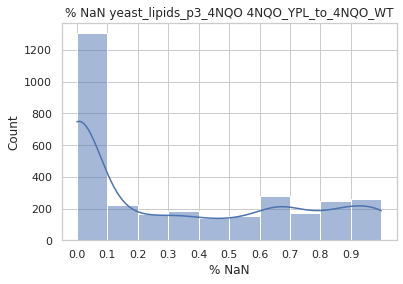

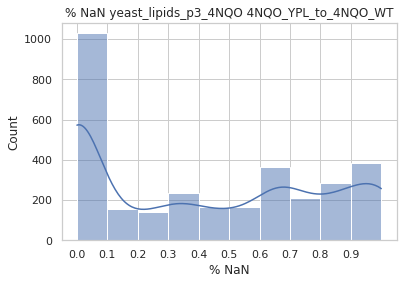

3141 3141
['4NQO_RPN4', '4NQO_YPL'] 4NQO_WT
['4NQO_RPN4', '4NQO_YPL'] 4NQO_WT
['4NQO_RPN4', '4NQO_YPL'] Normal_YPL
['4NQO_RPN4', '4NQO_YPL'] Normal_RPN4
['4NQO_RPN4', '4NQO_YPL'] 4NQO_YPL
['4NQO_RPN4', '4NQO_YPL'] Normal_WT
['4NQO_RPN4', '4NQO_YPL'] 4NQO_RPN4
['4NQO_RPN4', '4NQO_YPL'] Normal_WT
['4NQO_RPN4', '4NQO_YPL'] Normal_YPL
['4NQO_RPN4', '4NQO_YPL'] Normal_RPN4
['4NQO_RPN4', '4NQO_YPL'] Normal_RPN4
['4NQO_RPN4', '4NQO_YPL'] 4NQO_YPL
['4NQO_RPN4', '4NQO_YPL'] 4NQO_WT
['4NQO_RPN4', '4NQO_YPL'] 4NQO_WT
['4NQO_RPN4', '4NQO_YPL'] 4NQO_RPN4
['4NQO_RPN4', '4NQO_YPL'] 4NQO_YPL
['4NQO_RPN4', '4NQO_YPL'] 4NQO_YPL
['4NQO_RPN4', '4NQO_YPL'] 4NQO_RPN4
['4NQO_RPN4', '4NQO_YPL'] Normal_YPL
['4NQO_RPN4', '4NQO_YPL'] Normal_WT
['4NQO_RPN4', '4NQO_YPL'] 4NQO_RPN4
['4NQO_RPN4', '4NQO_YPL'] Normal_RPN4
['4NQO_RPN4', '4NQO_YPL'] Normal_WT
['4NQO_RPN4', '4NQO_YPL'] 4NQO_YPL
['4NQO_RPN4', '4NQO_YPL'] 4NQO_YPL
['4NQO_RPN4', '4NQO_YPL'] Normal_RPN4
['4NQO_RPN4', '4NQO_YPL'] 4NQO_WT
['4NQO_RPN4', '4NQO_Y

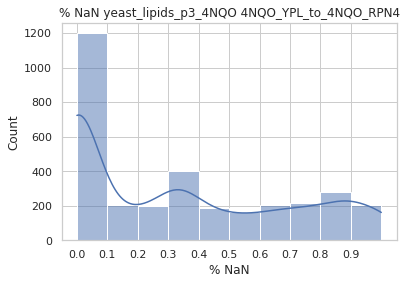

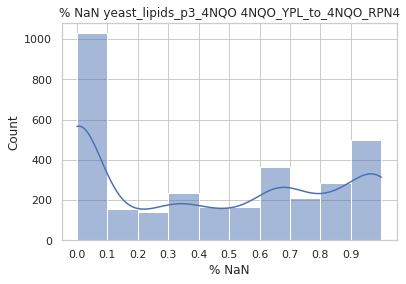

3252 3252
['EtOH_WT', 'EtOH_RPN4'] Normal_RPN4
['EtOH_WT', 'EtOH_RPN4'] Normal_YPL
['EtOH_WT', 'EtOH_RPN4'] EtOH_RPN4
['EtOH_WT', 'EtOH_RPN4'] EtOH_YPL
['EtOH_WT', 'EtOH_RPN4'] EtOH_YPL
['EtOH_WT', 'EtOH_RPN4'] EtOH_WT
['EtOH_WT', 'EtOH_RPN4'] Normal_WT
['EtOH_WT', 'EtOH_RPN4'] Normal_WT
['EtOH_WT', 'EtOH_RPN4'] Normal_RPN4
['EtOH_WT', 'EtOH_RPN4'] Normal_WT
['EtOH_WT', 'EtOH_RPN4'] Normal_YPL
['EtOH_WT', 'EtOH_RPN4'] Normal_WT
['EtOH_WT', 'EtOH_RPN4'] EtOH_WT
['EtOH_WT', 'EtOH_RPN4'] Normal_RPN4
['EtOH_WT', 'EtOH_RPN4'] Normal_YPL
['EtOH_WT', 'EtOH_RPN4'] Normal_YPL
['EtOH_WT', 'EtOH_RPN4'] EtOH_WT
['EtOH_WT', 'EtOH_RPN4'] EtOH_YPL
['EtOH_WT', 'EtOH_RPN4'] Normal_YPL
['EtOH_WT', 'EtOH_RPN4'] Normal_WT
['EtOH_WT', 'EtOH_RPN4'] Normal_RPN4
['EtOH_WT', 'EtOH_RPN4'] EtOH_YPL
['EtOH_WT', 'EtOH_RPN4'] Normal_RPN4
['EtOH_WT', 'EtOH_RPN4'] EtOH_YPL
['EtOH_WT', 'EtOH_RPN4'] Normal_WT
['EtOH_WT', 'EtOH_RPN4'] EtOH_WT
['EtOH_WT', 'EtOH_RPN4'] EtOH_YPL
['EtOH_WT', 'EtOH_RPN4'] EtOH_WT
['EtOH_WT',

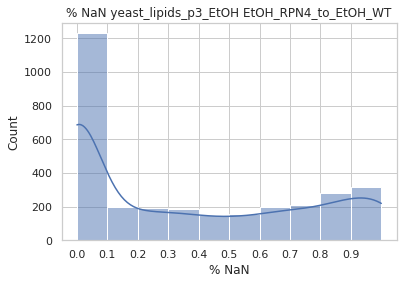

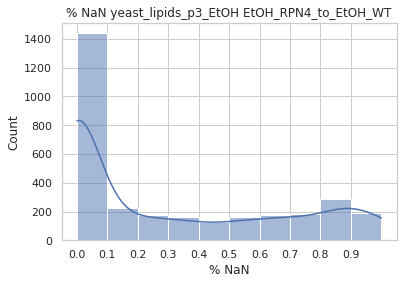

3121 3121
['EtOH_WT', 'EtOH_YPL'] Normal_RPN4
['EtOH_WT', 'EtOH_YPL'] Normal_YPL
['EtOH_WT', 'EtOH_YPL'] EtOH_RPN4
['EtOH_WT', 'EtOH_YPL'] EtOH_YPL
['EtOH_WT', 'EtOH_YPL'] EtOH_YPL
['EtOH_WT', 'EtOH_YPL'] EtOH_WT
['EtOH_WT', 'EtOH_YPL'] Normal_WT
['EtOH_WT', 'EtOH_YPL'] Normal_WT
['EtOH_WT', 'EtOH_YPL'] Normal_RPN4
['EtOH_WT', 'EtOH_YPL'] Normal_WT
['EtOH_WT', 'EtOH_YPL'] Normal_YPL
['EtOH_WT', 'EtOH_YPL'] Normal_WT
['EtOH_WT', 'EtOH_YPL'] EtOH_WT
['EtOH_WT', 'EtOH_YPL'] Normal_RPN4
['EtOH_WT', 'EtOH_YPL'] Normal_YPL
['EtOH_WT', 'EtOH_YPL'] Normal_YPL
['EtOH_WT', 'EtOH_YPL'] EtOH_WT
['EtOH_WT', 'EtOH_YPL'] EtOH_YPL
['EtOH_WT', 'EtOH_YPL'] Normal_YPL
['EtOH_WT', 'EtOH_YPL'] Normal_WT
['EtOH_WT', 'EtOH_YPL'] Normal_RPN4
['EtOH_WT', 'EtOH_YPL'] EtOH_YPL
['EtOH_WT', 'EtOH_YPL'] Normal_RPN4
['EtOH_WT', 'EtOH_YPL'] EtOH_YPL
['EtOH_WT', 'EtOH_YPL'] Normal_WT
['EtOH_WT', 'EtOH_YPL'] EtOH_WT
['EtOH_WT', 'EtOH_YPL'] EtOH_YPL
['EtOH_WT', 'EtOH_YPL'] EtOH_WT
['EtOH_WT', 'EtOH_YPL'] EtOH_RPN4
['EtO

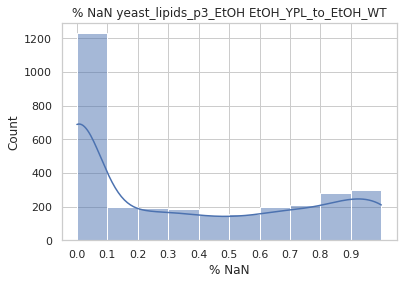

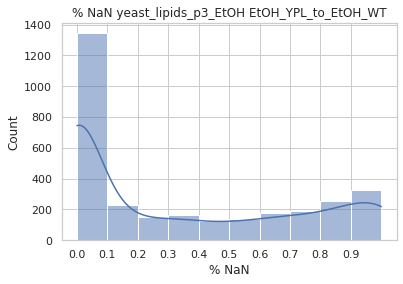

3103 3103
['EtOH_RPN4', 'EtOH_YPL'] Normal_RPN4
['EtOH_RPN4', 'EtOH_YPL'] Normal_YPL
['EtOH_RPN4', 'EtOH_YPL'] EtOH_RPN4
['EtOH_RPN4', 'EtOH_YPL'] EtOH_YPL
['EtOH_RPN4', 'EtOH_YPL'] EtOH_YPL
['EtOH_RPN4', 'EtOH_YPL'] EtOH_WT
['EtOH_RPN4', 'EtOH_YPL'] Normal_WT
['EtOH_RPN4', 'EtOH_YPL'] Normal_WT
['EtOH_RPN4', 'EtOH_YPL'] Normal_RPN4
['EtOH_RPN4', 'EtOH_YPL'] Normal_WT
['EtOH_RPN4', 'EtOH_YPL'] Normal_YPL
['EtOH_RPN4', 'EtOH_YPL'] Normal_WT
['EtOH_RPN4', 'EtOH_YPL'] EtOH_WT
['EtOH_RPN4', 'EtOH_YPL'] Normal_RPN4
['EtOH_RPN4', 'EtOH_YPL'] Normal_YPL
['EtOH_RPN4', 'EtOH_YPL'] Normal_YPL
['EtOH_RPN4', 'EtOH_YPL'] EtOH_WT
['EtOH_RPN4', 'EtOH_YPL'] EtOH_YPL
['EtOH_RPN4', 'EtOH_YPL'] Normal_YPL
['EtOH_RPN4', 'EtOH_YPL'] Normal_WT
['EtOH_RPN4', 'EtOH_YPL'] Normal_RPN4
['EtOH_RPN4', 'EtOH_YPL'] EtOH_YPL
['EtOH_RPN4', 'EtOH_YPL'] Normal_RPN4
['EtOH_RPN4', 'EtOH_YPL'] EtOH_YPL
['EtOH_RPN4', 'EtOH_YPL'] Normal_WT
['EtOH_RPN4', 'EtOH_YPL'] EtOH_WT
['EtOH_RPN4', 'EtOH_YPL'] EtOH_YPL
['EtOH_RPN4', 'Et

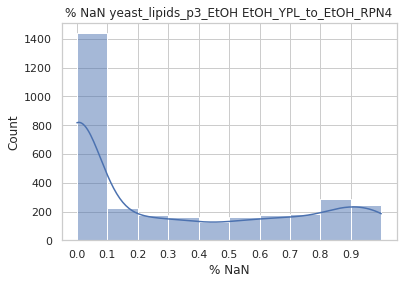

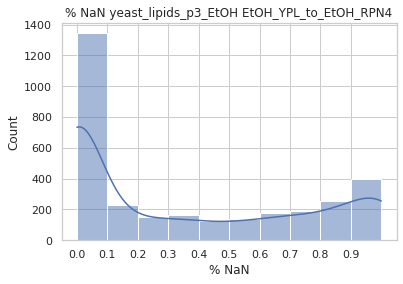

3177 3177


In [44]:
## дрожжи липидный обмен
# mv_dict = {}

# mv_dict.update(stat_test(input_dir = '/home/kae-13-1/diffacto/yeast/2019', 
#           output_dir = '/home/kae-13-1/diffacto/NSAF_files/new_mv_strategy/no drop/lipids', nsaf_data_name = 'yeast_lipids_p3_4NQO', 
#           sample_file = '/home/kae-13-1/diffacto/other/yeast/yeast_sample.csv', stattest = 'ttest_ind'))
# mv_dict.update(stat_test(input_dir = '/home/kae-13-1/diffacto/yeast/2017', 
#           output_dir = '/home/kae-13-1/diffacto/NSAF_files/new_mv_strategy/no drop/lipids', nsaf_data_name = 'yeast_lipids_p3_EtOH', 
#           sample_file = '/home/kae-13-1/diffacto/other/yeast/yeast_sample.csv', stattest = 'ttest_ind'))

In [45]:
with open('/home/kae-13-1/diffacto/other/mv_dictionary_yeast_lipids_p3.pickle', 'wb') as f:
    pickle.dump(mv_dict, f)

In [40]:
mv_dict

{'a172_dbtrg_DBTRG': [0.3762685402029664,
  0.4963985594237695,
  0.4849939975990396],
 'a172_dbtrg_A172': [0.3340562613430127,
  0.4390424481737414,
  0.4506416584402764],
 'glioblastoma_2019_3821': [0.44399533462033464,
  0.4692174913693901,
  0.44016110471806674],
 'glioblastoma_2019_4114': [0.47186072127937334,
  0.4232339089481947,
  0.4335949764521193],
 'glioblastoma_2019_5522': [0.4621284014919115,
  0.3750353806962921,
  0.3673931502971978],
 'glioblastoma_2019_6067': [0.45362965241464165,
  0.41939120631341603,
  0.4281285231116122],
 'glioblastoma_2019_AN': [0.4531224523071906,
  0.41421856639247945,
  0.4062867215041128],
 'glioblastoma_2017_infa_i': [0.4906300539083558,
  0.6363162014088182,
  0.6504043829898252],
 'glioblastoma_2017_infa_b': [0.4359104273377836,
  0.6424566768603466,
  0.5797655453618756],
 'glioblastoma_2017_infb_i': [0.4918634290313925,
  0.6323452938117524,
  0.7610504420176807],
 'glioblastoma_2017_infb_b': [0.4341016119328673,
  0.6510934393638171,
 

Index(['LUM00926_VG/DBTRG_K', 'LUM00938_VG/DBTRG_K', 'LUM00929_VG/DBTRG_K',
       'LUM00935_VG/DBTRG_K', 'LUM00937_VG/DBTRG_K', 'LUM00936_VG/DBTRG_K',
       'LUM00939_VG/DBTRG_K', 'LUM00928_VG/DBTRG_K', 'LUM00925_VG/DBTRG_K',
       'LUM00927_VG_160910015530/DBTRG_K'],
      dtype='object') 
 Index(['LUM00943_VG/DBTRG_I', 'LUM00931_VG/DBTRG_I', 'LUM00933_VG/DBTRG_I',
       'LUM00932_VG/DBTRG_I', 'LUM00930_VG/DBTRG_I', 'LUM00944_VG/DBTRG_I',
       'LUM00941_VG/DBTRG_I', 'LUM00934_VG/DBTRG_I', 'LUM00942_VG/DBTRG_I',
       'LUM00940_VG/DBTRG_I'],
      dtype='object')


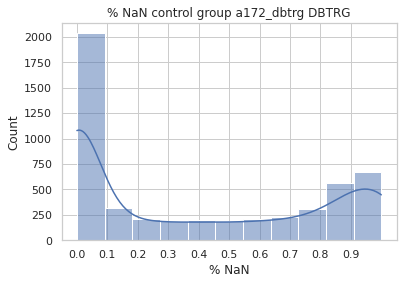

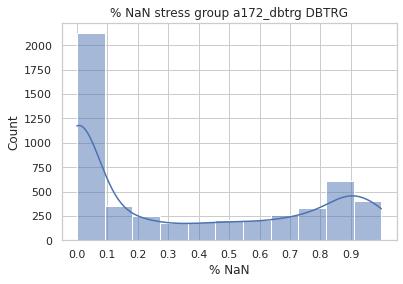

1792 proteins are dropped


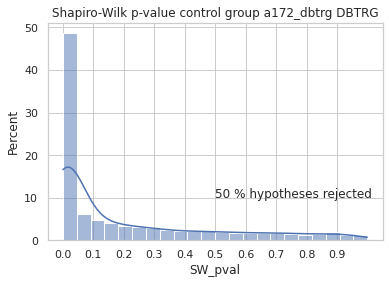

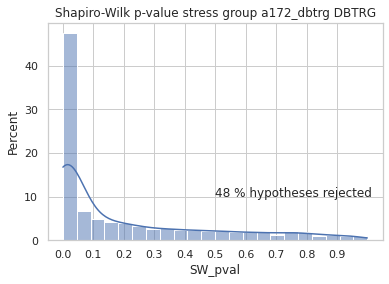

3332 3332
71
Index(['LUM00981_VG/A172_K', 'LUM00972_VG/A172_K', 'LUM00978_VG/A172_K',
       'LUM00970_VG/A172_K', 'LUM00969_VG/A172_K', 'LUM00980_VG/A172_K',
       'LUM00968_VG/A172_K', 'LUM00982_VG/A172_K', 'LUM00971_VG/A172_K',
       'LUM00979_VG/A172_K'],
      dtype='object') 
 Index(['LUM00973_VG/A172_I', 'LUM00975_VG/A172_I', 'LUM00983_VG/A172_I',
       'LUM00977_VG/A172_I', 'LUM00976_VG/A172_I', 'LUM00974_VG/A172_I',
       'LUM00984_VG/A172_I', 'LUM00987_VG/A172_I', 'LUM00986_VG/A172_I'],
      dtype='object')


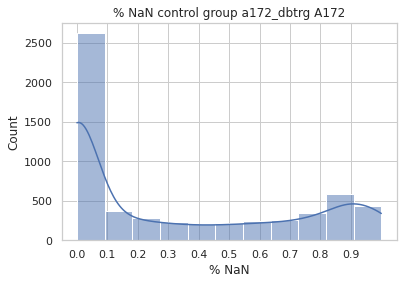

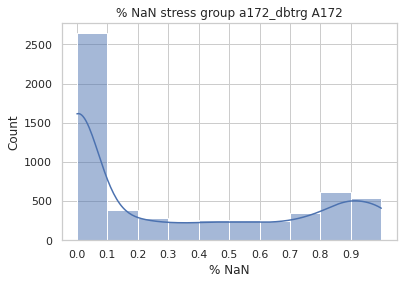

1748 proteins are dropped


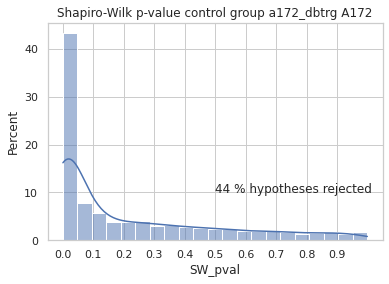

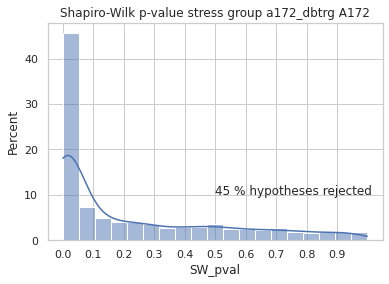

4052 4052
78
Index(['QEHF2_06998_JB/3821K', 'QEHF2_06999_JB/3821K', 'QEHF2_06948_JB/3821K',
       'QEHF2_06940_JB/3821K', 'QEHF2_06924_JB/3821K', 'QEHF2_06941_JB/3821K',
       'QEHF2_06949_JB/3821K', 'QEHF2_06925_JB/3821K'],
      dtype='object') 
 Index(['QEHF2_06942_JB/3821a', 'QEHF2_06986_JB/3821a', 'QEHF2_06928_JB/3821a',
       'QEHF2_06987_JB/3821a', 'QEHF2_06943_JB/3821a', 'QEHF2_06969_JB/3821a',
       'QEHF2_06929_JB/3821a', 'QEHF2_06968_JB/3821a'],
      dtype='object')


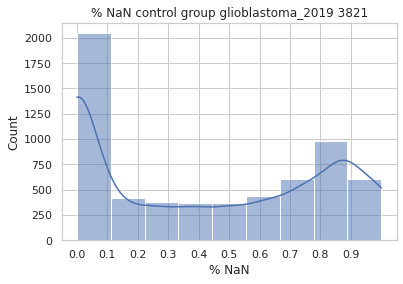

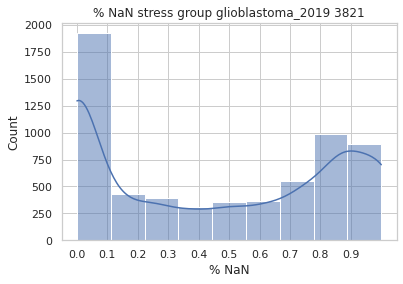

2740 proteins are dropped


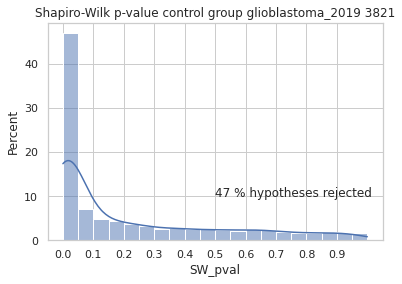

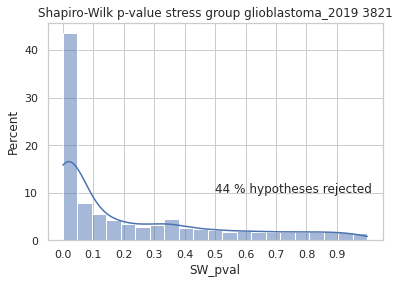

3476 3476
85
Index(['QEHF2_06950_JB/4114K', 'QEHF2_06934_JB/4114K', 'QEHF2_06973_JB/4114K',
       'QEHF2_07001_JB/4114K', 'QEHF2_06935_JB/4114K', 'QEHF2_06972_JB/4114K',
       'QEHF2_07000_JB/4114K', 'QEHF2_06951_JB/4114K'],
      dtype='object') 
 Index(['QEHF2_06976_JB/4114a', 'QEHF2_06994_JB/4114a', 'QEHF2_06977_JB/4114a',
       'QEHF2_06981_JB/4114a', 'QEHF2_06991_JB/4114a', 'QEHF2_06980_JB/4114a',
       'QEHF2_06995_JB/4114a', 'QEHF2_06990_JB/4114a'],
      dtype='object')


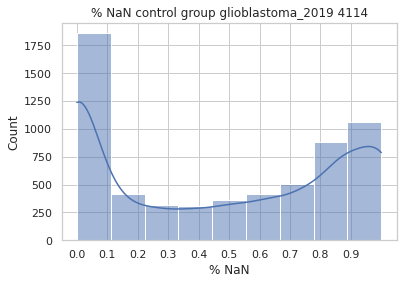

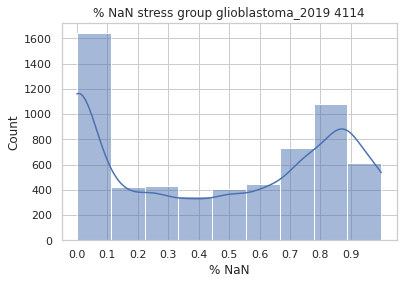

2943 proteins are dropped


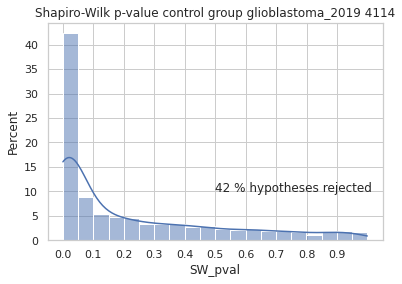

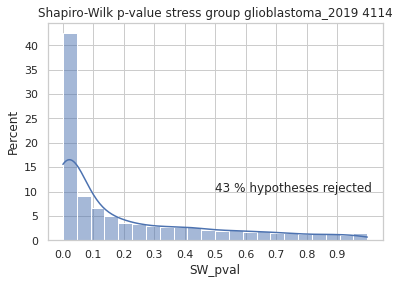

3185 3185
90
Index(['QEHF2_07004_JB/5522K', 'QEHF2_07005_JB/5522K', 'QEHF2_06985_JB/5522K',
       'QEHF2_06967_JB/5522K', 'QEHF2_06992_JB/5522K', 'QEHF2_06984_JB/5522K',
       'QEHF2_06993_JB/5522K', 'QEHF2_06966_JB/5522K'],
      dtype='object') 
 Index(['QEHF2_07002_JB/5522a', 'QEHF2_06988_JB/5522a', 'QEHF2_07003_JB/5522a',
       'QEHF2_06979_JB/5522a', 'QEHF2_06978_JB/5522a', 'QEHF2_06989_JB/5522a'],
      dtype='object')


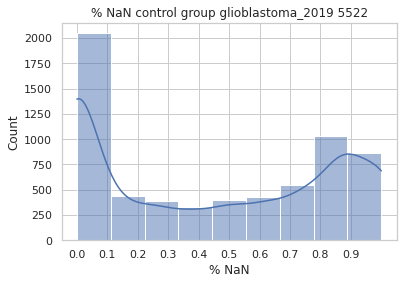

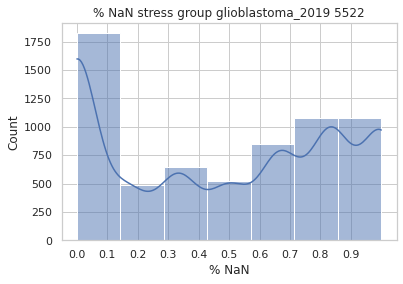

2940 proteins are dropped


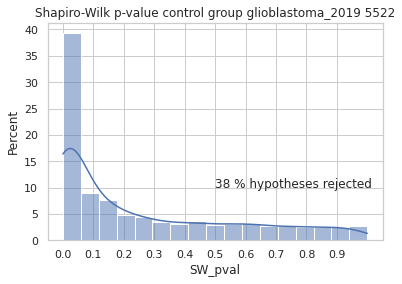

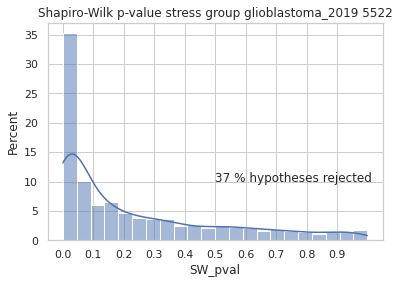

3533 3533
82
Index(['QEHF2_06927_JB/6067K', 'QEHF2_06919_JB/6067K', 'QEHF2_06917_JB/6067K',
       'QEHF2_06937_JB/6067K', 'QEHF2_06936_JB/6067K', 'QEHF2_06918_JB/6067K',
       'QEHF2_06926_JB/6067K', 'QEHF2_06916_JB/6067K'],
      dtype='object') 
 Index(['QEHF2_06930_JB/6067a', 'QEHF2_06921_JB/6067a', 'QEHF2_06922_JB/6067a',
       'QEHF2_06938_JB/6067a', 'QEHF2_06931_JB/6067a', 'QEHF2_06920_JB/6067a',
       'QEHF2_06939_JB/6067a', 'QEHF2_06923_JB/6067a'],
      dtype='object')


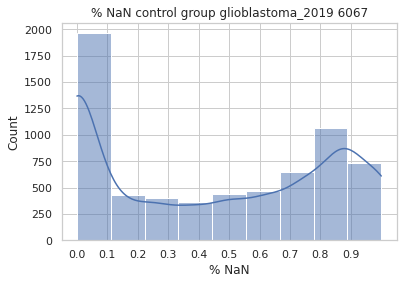

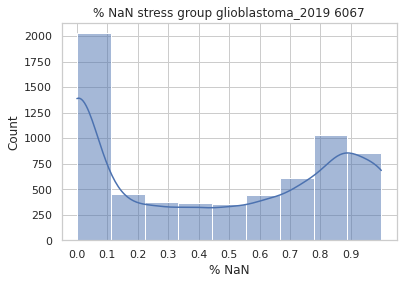

2954 proteins are dropped


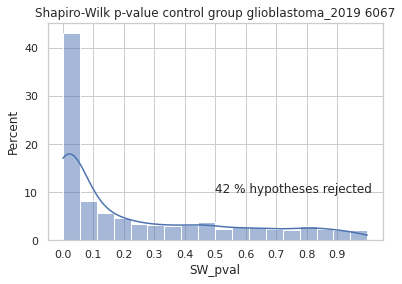

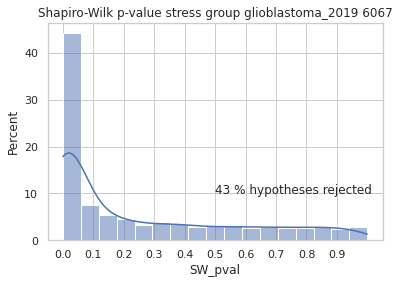

3548 3548
87
Index(['QEHF2_06933_JB/ANK', 'QEHF2_06997_JB/ANK', 'QEHF2_06996_JB/ANK',
       'QEHF2_06945_JB/ANK', 'QEHF2_06944_JB/ANK', 'QEHF2_06952_JB/ANK',
       'QEHF2_06953_JB/ANK', 'QEHF2_06932_JB/ANK'],
      dtype='object') 
 Index(['QEHF2_06974_JB/ANa', 'QEHF2_06954_JB/ANa', 'QEHF2_06975_JB/ANa',
       'QEHF2_06955_JB/ANa', 'QEHF2_06982_JB/ANa', 'QEHF2_06947_JB/ANa',
       'QEHF2_06946_JB/ANa', 'QEHF2_06983_JB/ANa'],
      dtype='object')


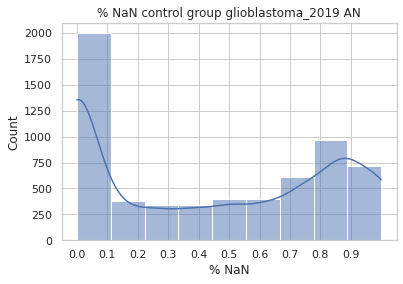

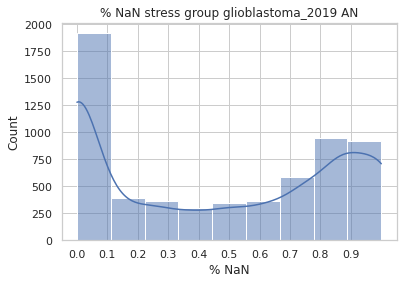

2729 proteins are dropped


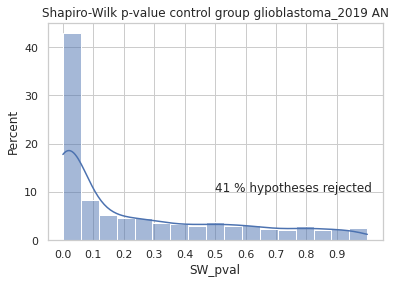

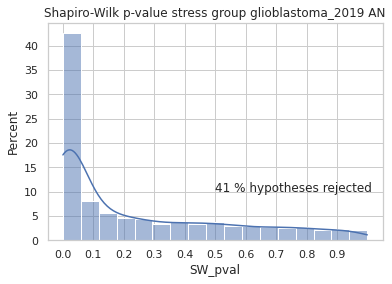

3404 3404
79
Index(['LUM2_00824_VG_6062K_1/i_K', 'LUM2_00787_VG_4466K_2/i_K',
       'LUM2_00736_VG_5410K_1/i_K', 'LUM2_00738_VG_5410K_3/i_K',
       'LUM2_00739_VG_5410K_4/i_K', 'LUM2_00721_VG_3821B_1/i_K',
       'LUM2_00789_VG_4466K_4/i_K', 'LUM2_00793_VG_6138K_4/i_K',
       'LUM2_00825_VG_6062K_2/i_K', 'LUM2_00790_VG_6138K_1/i_K',
       'LUM2_00791_VG_6138K_2/i_K', 'LUM2_00826_VG_6062K_3/i_K',
       'LUM2_00792_VG_6138K_3/i_K', 'LUM2_00786_VG_4466K_1/i_K',
       'LUM2_00724_VG_3821B_4/i_K', 'LUM2_00723_VG_3821B_3/i_K',
       'LUM2_00788_VG_4466K_3/i_K', 'LUM2_00827_VG_6062K_4/i_K',
       'LUM2_00737_VG_5410K_2/i_K', 'LUM2_00722_VG_3821B_2/i_K'],
      dtype='object') 
 Index(['LUM2_00728_VG_5410A_4/i_A', 'LUM2_00809_VG_6138A_4/i_A',
       'LUM2_00741_VG_3821A_2/i_A', 'LUM2_00844_VG_6062A_3/i_A',
       'LUM2_00806_VG_6138A_1/i_A', 'LUM2_00845_VG_6062A_4/i_A',
       'LUM2_00725_VG_5410A_1/i_A', 'LUM2_00795_VG_4466A_2/i_A',
       'LUM2_00796_VG_4466A_3/i_A', 'LUM2_00740_VG_3

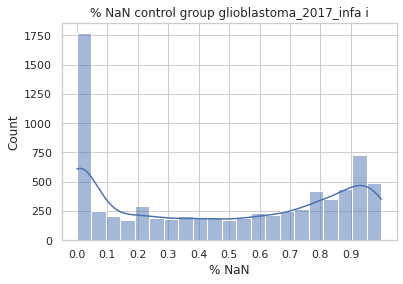

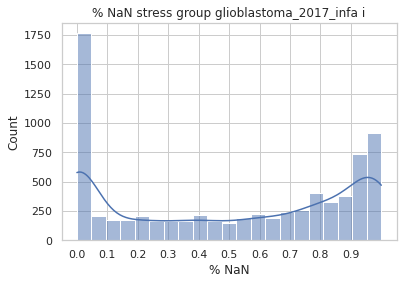

3587 proteins are dropped


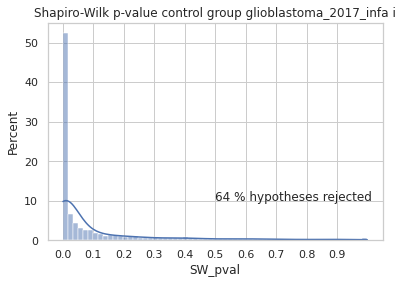

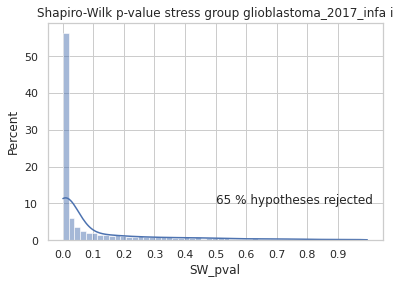

3833 3833
76
Index(['LUM2_00716_VG_5222K_4/b_K', 'LUM2_00717_VG_5222K_5/b_K',
       'LUM2_00833_VG_5522K_6/b_K', 'LUM2_00715_VG_5222K_3/b_K',
       'LUM2_00713_VG_5222K_1/b_K', 'LUM2_00839_VG_4114K_5/b_K',
       'LUM2_00718_VG_5222K_6/b_K', 'LUM2_00719_VG_5222K_7/b_K',
       'LUM2_00720_VG_5222K_8/b_K', 'LUM2_00838_VG_4114K_4/b_K',
       'LUM2_00841_VG_4114K_7/b_K', 'LUM2_00714_VG_5222K_2/b_K',
       'LUM2_00830_VG_5522K_3/b_K', 'LUM2_00837_VG_4114K_3/b_K',
       'LUM2_00832_VG_5522K_5/b_K', 'LUM2_00835_VG_4114K_1/b_K',
       'LUM2_00840_VG_4114K_6/b_K', 'LUM2_00828_VG_5522K_1/b_K',
       'LUM2_00829_VG_5522K_2/b_K', 'LUM2_00836_VG_4114K_2/b_K',
       'LUM2_00831_VG_5522K_4/b_K', 'LUM2_00834_VG_5522K_7/b_K'],
      dtype='object') 
 Index(['LUM2_00729_VG_5222A_1/b_A', 'LUM2_02401_VG_5522A_3/b_A',
       'LUM2_00732_VG_5222A_4/b_A', 'LUM2_00731_VG_5222A_3/b_A',
       'LUM2_02402_VG_5522A_4/b_A', 'LUM2_00857_VG_4114A_5/b_A',
       'LUM2_02399_VG_5522A_1/b_A', 'LUM2_00854_VG_4

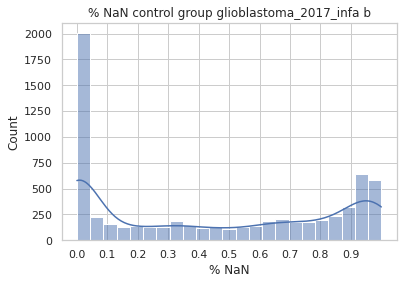

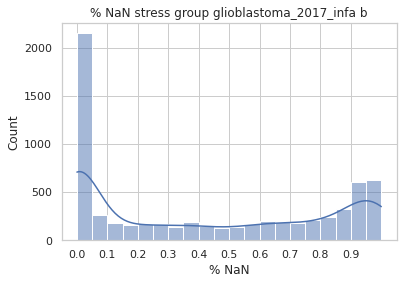

2671 proteins are dropped


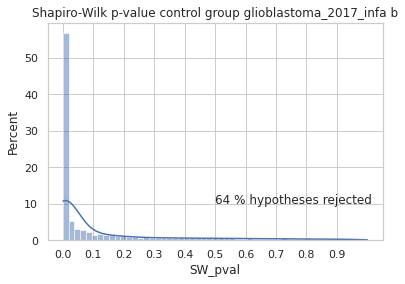

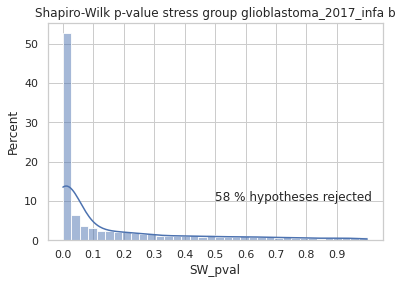

3924 3924
73
Index(['LUM2_00824_VG_6062K_1/i_K', 'LUM2_00787_VG_4466K_2/i_K',
       'LUM2_00736_VG_5410K_1/i_K', 'LUM2_00738_VG_5410K_3/i_K',
       'LUM2_00739_VG_5410K_4/i_K', 'LUM2_00721_VG_3821B_1/i_K',
       'LUM2_00789_VG_4466K_4/i_K', 'LUM2_00793_VG_6138K_4/i_K',
       'LUM2_00825_VG_6062K_2/i_K', 'LUM2_00790_VG_6138K_1/i_K',
       'LUM2_00791_VG_6138K_2/i_K', 'LUM2_00826_VG_6062K_3/i_K',
       'LUM2_00792_VG_6138K_3/i_K', 'LUM2_00786_VG_4466K_1/i_K',
       'LUM2_00724_VG_3821B_4/i_K', 'LUM2_00723_VG_3821B_3/i_K',
       'LUM2_00788_VG_4466K_3/i_K', 'LUM2_00827_VG_6062K_4/i_K',
       'LUM2_00737_VG_5410K_2/i_K', 'LUM2_00722_VG_3821B_2/i_K'],
      dtype='object') 
 Index(['LUM2_00805_VG_4466B_4/i_B', 'LUM2_00710_VG_3821K_2/i_B',
       'LUM2_00705_VG_5410B_1/i_B', 'LUM2_00798_VG_6138B_1/i_B',
       'LUM2_00803_VG_4466B_2/i_B', 'LUM2_00711_VG_3821K_3/i_B',
       'LUM2_00861_VG_6062B_2/i_B', 'LUM2_00800_VG_6138B_3/i_B',
       'LUM2_00706_VG_5410B_2/i_B', 'LUM2_00801_VG_6

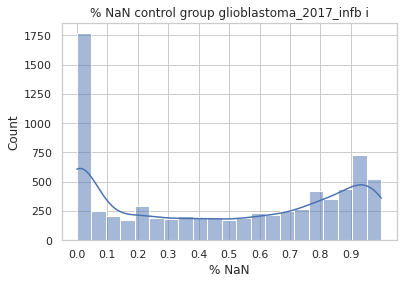

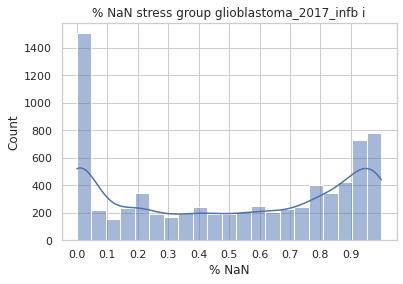

3608 proteins are dropped


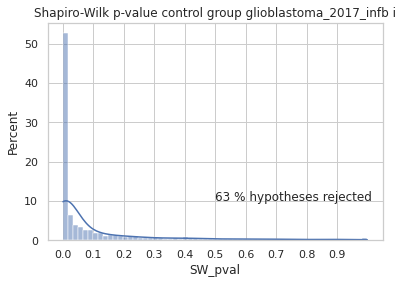

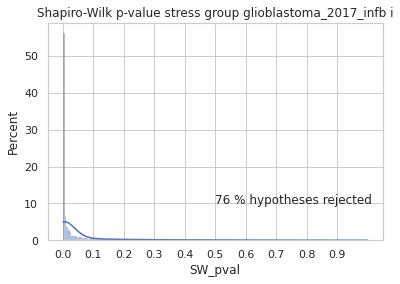

3846 3846
87
Index(['LUM2_00716_VG_5222K_4/b_K', 'LUM2_00717_VG_5222K_5/b_K',
       'LUM2_00833_VG_5522K_6/b_K', 'LUM2_00715_VG_5222K_3/b_K',
       'LUM2_00713_VG_5222K_1/b_K', 'LUM2_00839_VG_4114K_5/b_K',
       'LUM2_00718_VG_5222K_6/b_K', 'LUM2_00719_VG_5222K_7/b_K',
       'LUM2_00720_VG_5222K_8/b_K', 'LUM2_00838_VG_4114K_4/b_K',
       'LUM2_00841_VG_4114K_7/b_K', 'LUM2_00714_VG_5222K_2/b_K',
       'LUM2_00830_VG_5522K_3/b_K', 'LUM2_00837_VG_4114K_3/b_K',
       'LUM2_00832_VG_5522K_5/b_K', 'LUM2_00835_VG_4114K_1/b_K',
       'LUM2_00840_VG_4114K_6/b_K', 'LUM2_00828_VG_5522K_1/b_K',
       'LUM2_00829_VG_5522K_2/b_K', 'LUM2_00836_VG_4114K_2/b_K',
       'LUM2_00831_VG_5522K_4/b_K', 'LUM2_00834_VG_5522K_7/b_K'],
      dtype='object') 
 Index(['LUM2_00823_VG_4114B_7/b_B', 'LUM2_00810_VG_5522B_1/b_B',
       'LUM2_00821_VG_4114B_5/b_B', 'LUM2_00813_VG_5522B_4/b_B',
       'LUM2_00747_VG_5222B_4/b_B', 'LUM2_00744_VG_5222B_1/b_B',
       'LUM2_00822_VG_4114B_6/b_B', 'LUM2_00814_VG_5

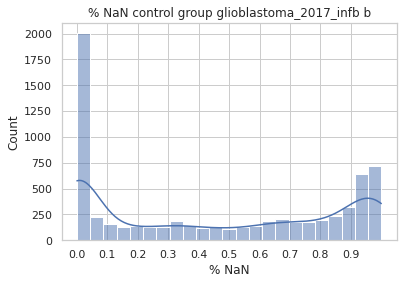

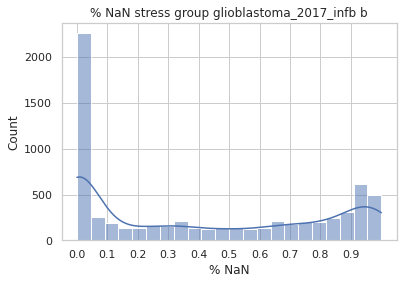

2702 proteins are dropped


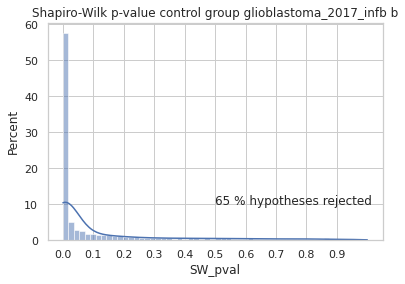

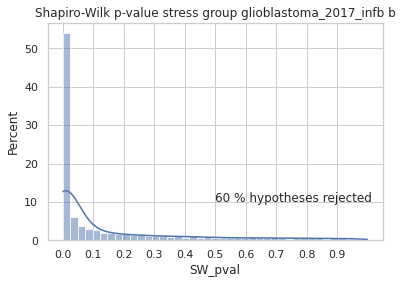

4024 4024
69
Index(['OEI13665/4_K', 'OEI13635/4_K', 'OEI13603/4_K', 'OEI13601/4_K',
       'OEI13655/4_K', 'OEI13641/4_K', 'OEI13597/4_K', 'OEI13639/4_K'],
      dtype='object') 
 Index(['OEI13515/4_A', 'OEI13645/4_A', 'OEI13566/4_A', 'OEI13536/4_A',
       'OEI13647/4_A', 'OEI13552/4_A', 'OEI13627/4_A', 'OEI13605/4_A'],
      dtype='object')


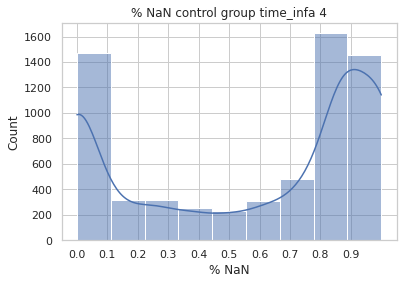

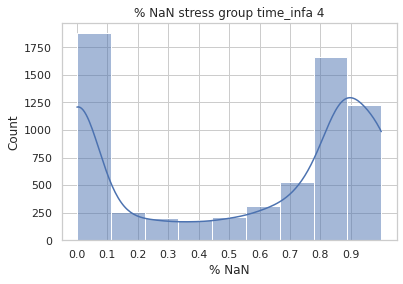

3775 proteins are dropped


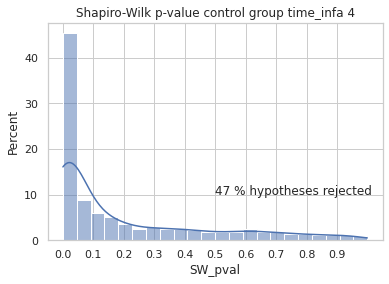

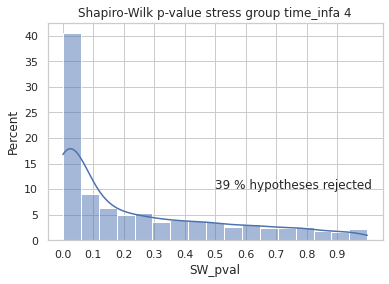

2676 2676
81
Index(['OEI13629/24_K', 'OEI13619/24_K', 'OEI13617/24_K', 'OEI13544/24_K',
       'OEI13513/24_K', 'OEI13520/24_K', 'OEI13572/24_K', 'OEI13522/24_K'],
      dtype='object') 
 Index(['OEI13528/24_A', 'OEI13667/24_A', 'OEI13546/24_A', 'OEI13591/24_A',
       'OEI13631/24_A', 'OEI13507/24_A', 'OEI13582/24_A', 'OEI13540/24_A'],
      dtype='object')


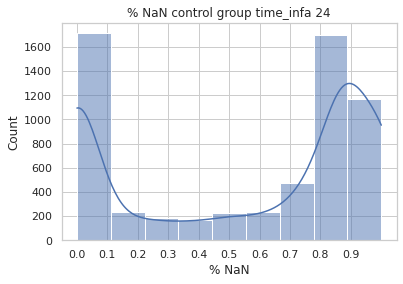

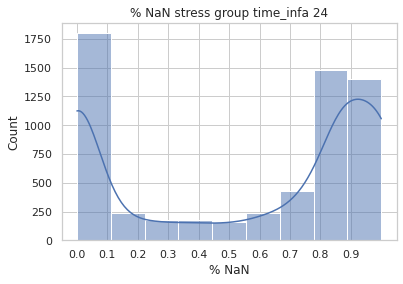

3552 proteins are dropped


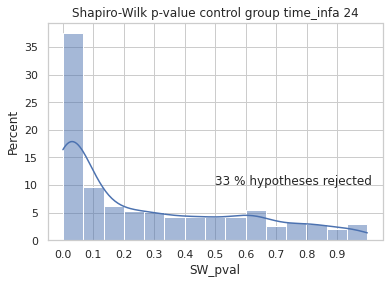

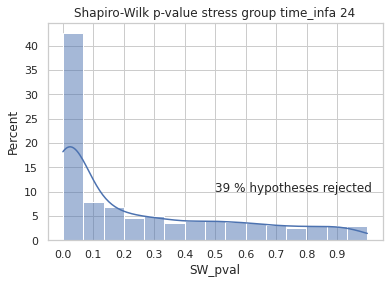

2550 2550
78
Index(['OEI13564/48_K', 'OEI13534/48_K', 'OEI13526/48_K', 'OEI13671/48_K',
       'OEI13607/48_K', 'OEI13562/48_K', 'OEI13625/48_K', 'OEI13651/48_K'],
      dtype='object') 
 Index(['OEI13548/48_A', 'OEI13558/48_A', 'OEI13574/48_A', 'OEI13609/48_A',
       'OEI13511/48_A', 'OEI13509/48_A', 'OEI13517/48_A', 'OEI13599/48_A'],
      dtype='object')


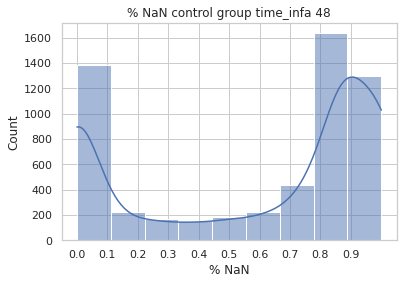

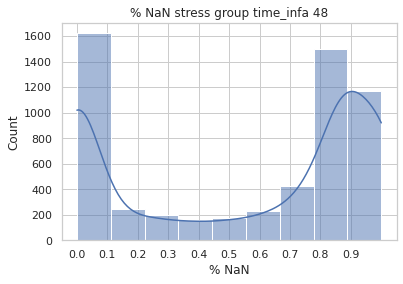

3429 proteins are dropped


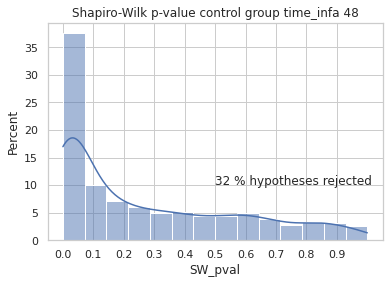

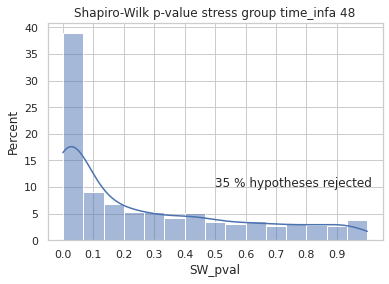

2290 2290
86
Index(['OEI13665/4_K', 'OEI13635/4_K', 'OEI13603/4_K', 'OEI13601/4_K',
       'OEI13655/4_K', 'OEI13641/4_K', 'OEI13597/4_K', 'OEI13639/4_K'],
      dtype='object') 
 Index(['OEI13661/4_G', 'OEI13611/4_G', 'OEI13657/4_G', 'OEI13570/4_G',
       'OEI13538/4_G', 'OEI13613/4_G'],
      dtype='object')


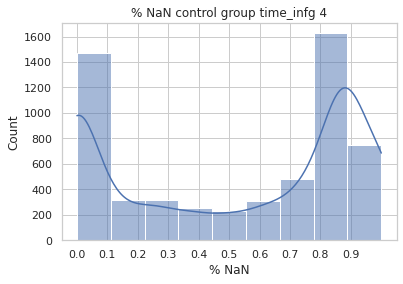

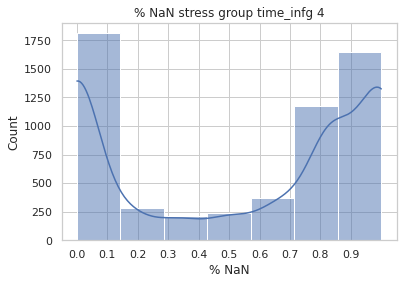

3153 proteins are dropped


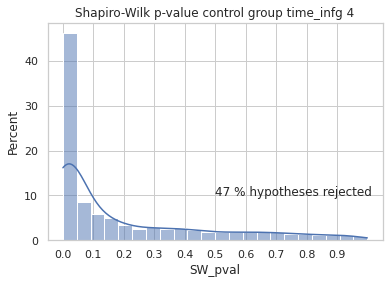

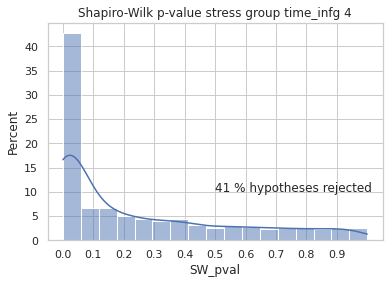

2591 2591
70
Index(['OEI13629/24_K', 'OEI13619/24_K', 'OEI13617/24_K', 'OEI13544/24_K',
       'OEI13513/24_K', 'OEI13520/24_K', 'OEI13572/24_K', 'OEI13522/24_K'],
      dtype='object') 
 Index(['OEI13580/24_G', 'OEI13637/24_G', 'OEI13663/24_G', 'OEI13593/24_G',
       'OEI13568/24_G', 'OEI13556/24_G', 'OEI13621/24_G'],
      dtype='object')


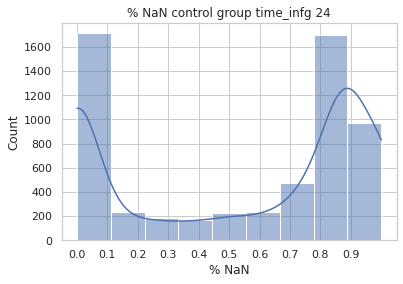

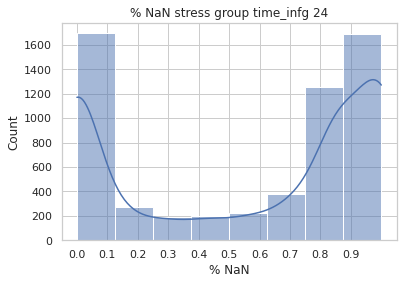

3236 proteins are dropped


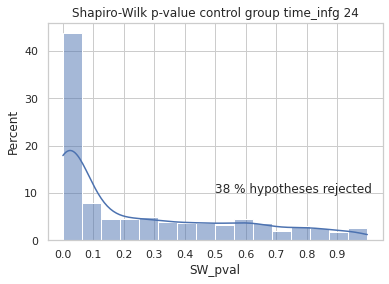

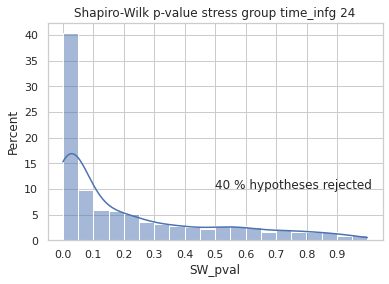

2670 2670
57
Index(['OEI13564/48_K', 'OEI13534/48_K', 'OEI13526/48_K', 'OEI13671/48_K',
       'OEI13607/48_K', 'OEI13562/48_K', 'OEI13625/48_K', 'OEI13651/48_K'],
      dtype='object') 
 Index(['OEI13554/48_G', 'OEI13530/48_G', 'OEI13653/48_G', 'OEI13576/48_G',
       'OEI13578/48_G', 'OEI13595/48_G', 'OEI13623/48_G', 'OEI13649/48_G'],
      dtype='object')


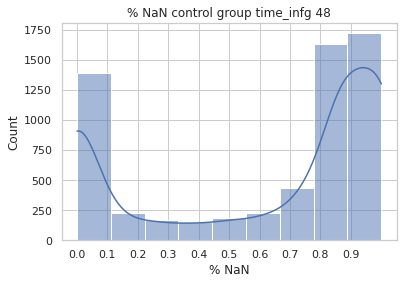

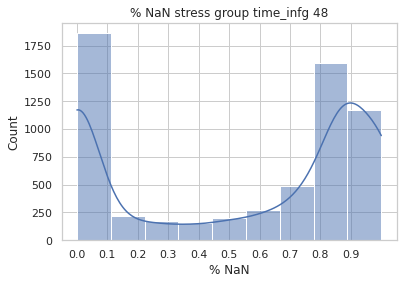

3621 proteins are dropped


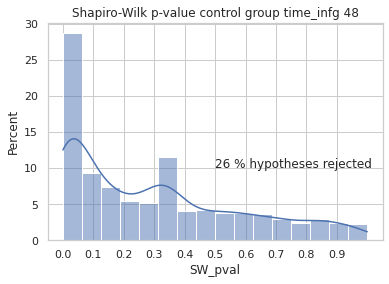

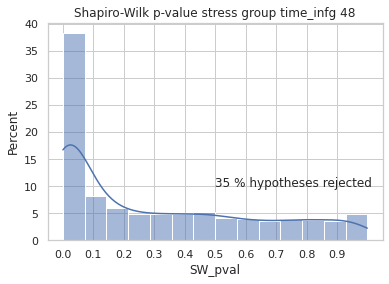

2520 2520
60


In [20]:
mv_dict = {}

mv_dict.update(stat_test(input_dir = '/home/kae-13-1/Metrics/a172_dbtrg',
                            output_dir = '/home/kae-13-1/Metrics/Mar2022/16_03', nsaf_data_name = 'a172_dbtrg',
                            sample_file = '/home/kae-13-1/Metrics/other/a172_dbtrg/a172_dbtrg_sample.csv',
                            stattest = 'ttest_ind'))
mv_dict.update(stat_test(input_dir = '/home/kae-13-1/Metrics/glioblastoma/2019',
                            output_dir = '/home/kae-13-1/Metrics/Mar2022/16_03', nsaf_data_name = 'glioblastoma_2019',
                            sample_file = '/home/kae-13-1/Metrics/other/glioblastoma/sample_gbm_2019_upd.csv',
                            stattest = 'ttest_ind'))
mv_dict.update(stat_test(input_dir = '/home/kae-13-1/Metrics/glioblastoma/2017',
                            output_dir = '/home/kae-13-1/Metrics/Mar2022/16_03', nsaf_data_name = 'glioblastoma_2017_infa',
                            sample_file = '/home/kae-13-1/Metrics/other/glioblastoma/glioblastoma_infa_infb_sample_groups.csv',
                            stattest = 'ttest_ind'))
mv_dict.update(stat_test(input_dir = '/home/lab006/Data/External/Denmark/Glioblastoma/May_2017/ifna_ifnb/identipy',
                            output_dir = '/home/kae-13-1/Metrics/Mar2022/16_03', nsaf_data_name = 'glioblastoma_2017_infb',
                            sample_file = '/home/kae-13-1/Metrics/other/glioblastoma/glioblastoma_infa_infb_sample_groups.csv',
                            stattest = 'ttest_ind'))
mv_dict.update(stat_test(input_dir = '/home/kae-13-1/Metrics/time_inf',
                            output_dir = '/home/kae-13-1/Metrics/Mar2022/16_03', nsaf_data_name = 'time_infa',
                            sample_file = '/home/kae-13-1/Metrics/other/time_inf_samplefile.csv',
                            stattest = 'ttest_ind'))
mv_dict.update(stat_test(input_dir = '/home/kae-13-1/Metrics/time_inf',
                            output_dir = '/home/kae-13-1/Metrics/Mar2022/16_03', nsaf_data_name = 'time_infg',
                            sample_file = '/home/kae-13-1/Metrics/other/time_inf_samplefile.csv',
                            stattest = 'ttest_ind'))

In [41]:
dataname_to_plot = {'time_infg_48':'MRC5 IFNg 500 48h',
                   'time_infg_24' : 'MRC5 IFNg 500 24h',
                   'a172_dbtrg_DBTRG' :  'DBTRG IFNa-2b 1000 24h',
                   'glioblastoma_2017_infa_b' : 'GBM2017b IFNa-2b 100 24h',
                   'a172_dbtrg_A172' : 'HOS IFNa-2b 1000 24h',
                   'time_infg_4' : 'MRC5 IFNg 500 4h',
                   'glioblastoma_2017_infa_i' : 'GBM2017i IFNa-2b 100 24h',
                   'glioblastoma_2019_5522' : 'GBM5522 IFNa-2b 100 24h',
                   'time_infa_4' : 'MRC5 IFNa-2b 500 4h',
                   'glioblastoma_2019_AN' : 'AN IFNa-2b 100 24h',
                   'glioblastoma_2017_infb_i' : 'GBM2017i IFNb-2b 1000 24h',
                   'glioblastoma_2017_infb_b' : 'GBM2017b IFNb-2b 1000 24h',
                    'time_infa_24' : 'MRC5 IFNa-2b 500 24h',
                    'glioblastoma_2019_6067' : 'GBM6067 IFNa-2b 100 24h',
                    'time_infa_48' : 'MRC5 IFNa-2b 500 48h',
                    'glioblastoma_2019_3821' : 'GBM3821 IFNa-2b 100 24h',
                    'glioblastoma_2019_4114' : 'GBM4114 IFNa-2b 100 24h'}
mv_df = pd.DataFrame(index = list(dataname_to_plot.values()), columns = ['mean mv by proteins', 'sw stress %', 'sw control %'])


for k in mv_dict.keys():
    i = dataname_to_plot[k]
    mv_df.loc[i, 'mean mv by proteins'] = mv_dict[k][0]
    mv_df.loc[i, 'sw stress %'] = mv_dict[k][2]
    mv_df.loc[i, 'sw control %'] = mv_dict[k][1] 
    
mv_df.to_csv('/home/kae-13-1/Metrics/MinDet_ST_df.tsv', sep = '\t')